In [ ]:
!pip install pandas matplotlib seaborn scikit-learn xgboost imbalanced-learn --quiet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
df = pd.read_csv("Train.csv")
print("✅ Columns in dataset:", df.columns.tolist())
df.head()

✅ Columns in dataset: ['ID', 'Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms', 'Reached.on.Time_Y.N']


,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


<Axes: >

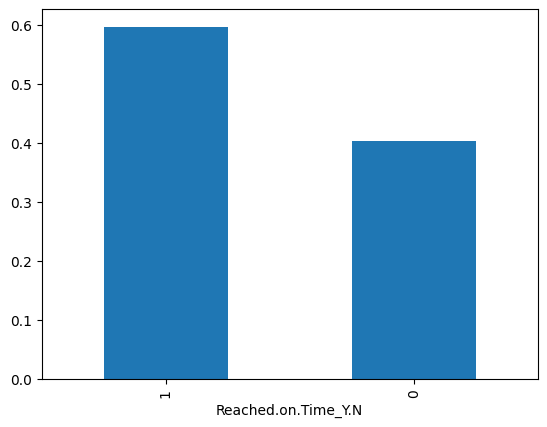

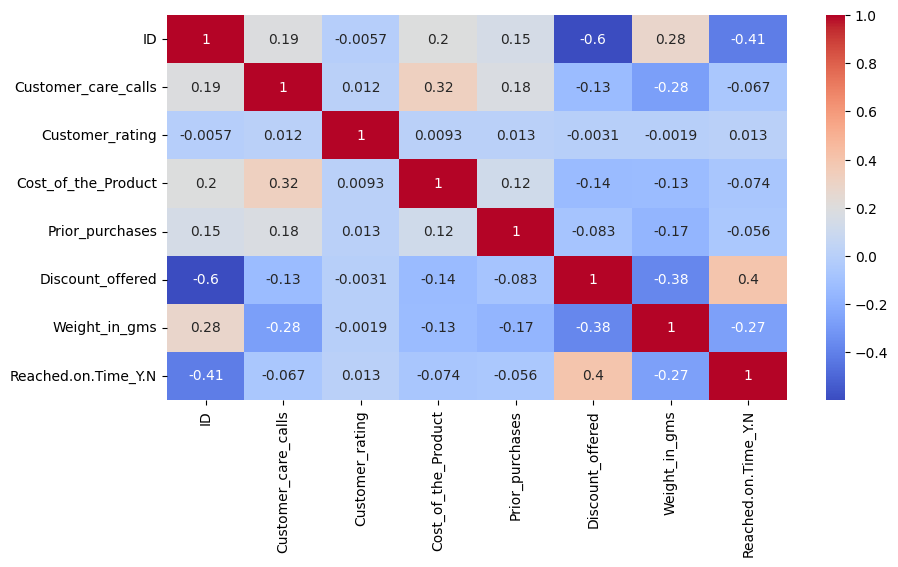

In [ ]:
## Step 3: Exploratory Data Analysis
df.info()
df.describe()
df['Reached.on.Time_Y.N'].value_counts(normalize=True).plot(kind='bar')

plt.figure(figsize=(10,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')

In [ ]:
## Step 4: Feature Engineering
df['Cost_of_the_Product_log'] = np.log1p(df['Cost_of_the_Product'])

# Bucketize Weight
df['Weight_bucket'] = pd.cut(df['Weight_in_gms'], bins=[0, 2000, 5000, 8000], labels=['Light', 'Medium', 'Heavy'])
df = pd.get_dummies(df, columns=['Weight_bucket'], drop_first=True)

# Encode other categorical columns
df = pd.get_dummies(df, columns=['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender'], drop_first=True)

# Drop unused columns
df.drop(['ID', 'Cost_of_the_Product'], axis=1, inplace=True)

In [ ]:
## Step 5: Feature Selection (Variance Threshold)
X = df.drop('Reached.on.Time_Y.N', axis=1)
y = df['Reached.on.Time_Y.N']
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X)

In [ ]:
## Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

## Step 7: SMOTE Oversampling
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
## Step 8: Scaling
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

In [ ]:
## Step 9: Model Tuning with GridSearchCV (Random Forest)
params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid=params, cv=5)
grid.fit(X_train_res, y_train_res)

print("Best Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

best_model = grid.best_estimator_

Best Parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
Best CV Score: 0.7359263608569326


In [ ]:
## Step 10: Evaluation
y_pred = best_model.predict(X_test)
y_probs = best_model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_probs))

Confusion Matrix:
 [[866  29]
 [656 649]]

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.97      0.72       895
           1       0.96      0.50      0.65      1305

    accuracy                           0.69      2200
   macro avg       0.76      0.73      0.69      2200
weighted avg       0.80      0.69      0.68      2200

ROC-AUC Score: 0.7527455639033369
